# Temperature forecast for the general public (MAELSTROM-Yr dataset)

This dataset contains temperature weather forecast for the Nordic region, and are used to produce public weather forecasts on the weather app Yr (www.yr.no). The goal of the prediction task is to generate a deterministic temperature forecast together with an uncertainty range (10% to 90%) as shown here: https://www.yr.no/en/details/graph/5-18700/Norway/Oslo/Oslo/Oslo%20(Blindern).

The target field in the dataset is constructed using a high density network of citizen weather stations from [Netatmo](https://weathermap.netatmo.com/).

The current operational implementation uses a very simple regression model based on only a subset of the predictors available in the dataset. It is described in this article: https://journals.ametsoc.org/view/journals/bams/101/1/bams-d-18-0237.1.xml

## Prerequisites
To run the code in this notebook, you need the following packages:

`pip install climetlab climetlab_maelstrom_yr keras tensorflow numpy matplotlib`

In [168]:
!pip install climetlab climetlab_maelstrom_yr

  Using cached xarray-0.20.2-py3-none-any.whl (845 kB)


## Loading the data
We can use climetlab to load the dataset into an xarray dataset. There will be several datasets available of different sizes: 300 MB (not available yet), 5GB, and 5TB (not available yet). The 5TB dataset contains the entire Nordic domain at 1x1 km resolution for all 60 hour leadtimes. The 5GB dataset contains only a subset of grid points (128x128) surrounding Oslo, Norway and only for leadtimes 6, 12, ..., 42 hours. All datasets contain the same input predictors and time period (4 years).

Currently, only "air_temperature" is available as the predictand parameter, however precipitation_amount will be added in the future.

The entire 5GB dataset will take a few minutes to load, since the data must be downloaded from europeanweather.cloud. Climetlab caches files locally, so files need not be when rerunning the code later. To only load a subset, add a dates argument to load_dataset, e.g. `dates=['2017-01-01', '2017-01-02']` or `dates=pandas.date_range(start="2017-01-01", end="2017-03-01", freq="1D")`.

In [104]:
# import climetlab as cml
# import pandas
# cmlds = cml.load_dataset(
#         'maelstrom-yr',
#         size='5GB',
#         parameter='air_temperature',
#     )
# ds = cmlds.to_xarray()

In [169]:
import climetlab as cml
import pandas
import xarray as xr

This dataset contains the following dimensions and variables

In [277]:
ds = xr.open_dataset("ap1-data.nc")
ds

<xarray.Dataset>
Dimensions:          (char: 50, leadtime: 8, predictor: 49, record: 1457, x: 128, y: 128)
Coordinates:
  * x                (x) float32 -2.974e+05 -2.964e+05 ... -1.714e+05 -1.704e+05
  * y                (y) float32 -5.043e+05 -5.033e+05 ... -3.783e+05 -3.773e+05
  * leadtime         (leadtime) timedelta64[ns] 00:00:00 ... 1 days 18:00:00
    latitude         (y, x) float32 ...
    longitude        (y, x) float32 ...
Dimensions without coordinates: char, predictor, record
Data variables:
    time             (record) datetime64[ns] ...
    projection       int32 ...
    altitude         (y, x) float32 ...
    predictors       (record, y, x, predictor) float32 ...
    name_predictor   (predictor, char) |S1 ...
    units_predictor  (predictor, char) |S1 ...
    target           (record, y, x, leadtime) float32 ...

The dataset is mostly self explanatory. The `record` dimension represent different samples. The `predictor` variable contains all predictors stacked one after the other, including values for different leadtimes. The `target` variable contain target values.

### Plotting predictors and predictand (target)

In [319]:
import matplotlib.pyplot as plt
import numpy as np

names = ds["name_predictor"].values
names = np.array([''.join([qq.decode('utf-8') for qq in names[p, :]]) for p in range(names.shape[0])])

num_leadtimes = len(ds["leadtime"])

unique_predictor_names = np.unique(names)
print("Available predictors:", unique_predictor_names)

Available predictors: ['air_temperature_2m' 'bias_recent' 'bias_yesterday' 'cloud_area_fraction'
 'precipitation_amount' 'x_wind_10m' 'y_wind_10m']


Text(0.5, 1.0, 'Target')

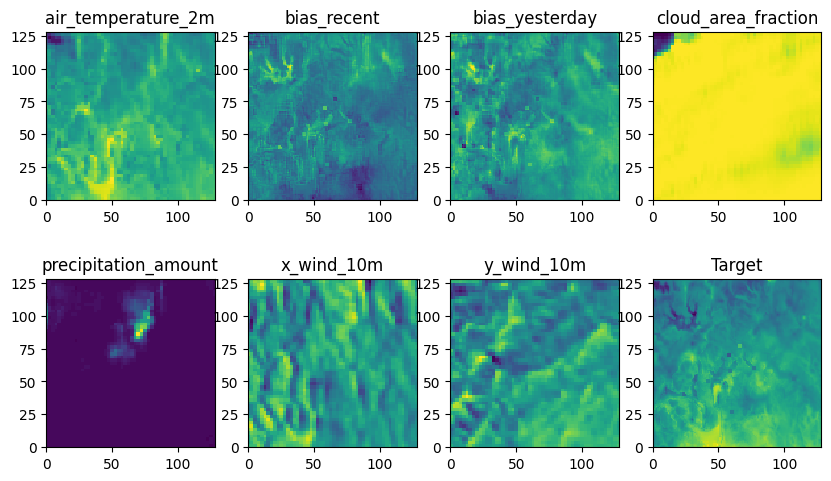

In [320]:
index_date = 0
target = ds["target"].values
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [10, 6]
for i, name in enumerate(unique_predictor_names):
    plt.subplot(2, 4, i + 1)
    index = np.where(names == name)[0][0]
    plt.pcolormesh(ds["predictors"][index_date, :, :, index], shading="auto", rasterized=True)
    plt.gca().set_aspect(1)
    plt.title(name)
plt.subplot(2, 4, 8)
plt.pcolormesh(target[index_date, :, :, 0], shading="auto", rasterized=True)
plt.gca().set_aspect(1)
plt.title("Target")

## Example ML solution
### Normalizing the predictors

First we normalize the predictors, by subtractng the mean and dividing by the standard deviation:

In [321]:
raw_forecast = np.copy(ds["predictors"][:, :, :, 0:num_leadtimes])
inputs = np.copy(ds["predictors"].values)
predictors = inputs[:,:,:,:-1]
num_predictors = 6
print("predictors",predictors[0,0,0,:])

predictors [ 6.6445923e-01 -2.6526794e+00 -1.8856812e-01 -1.8451233e+00
 -4.9484558e+00 -5.3280029e+00 -3.5876770e+00 -6.2725525e+00
  3.1510315e+00  3.0294800e-01 -6.3345337e-01 -1.1092529e+00
  3.1510315e+00  3.0294800e-01 -6.3345337e-01 -1.1092529e+00
  9.8587036e-01  0.0000000e+00  3.5095215e-03  9.9618530e-01
  0.0000000e+00  3.0822754e-03  3.0517578e-05  1.3092041e-02
  0.0000000e+00  0.0000000e+00  0.0000000e+00  2.2888184e-05
  2.2888184e-05  3.8146973e-05  2.2888184e-05  7.6293945e-06
  3.1973114e+00  2.2683105e+00  1.7007027e+00 -1.3430700e+00
  1.0218554e+00  2.9737940e+00  1.6690178e+00  1.5115967e+00
  1.4268494e-01 -2.4066467e+00 -4.8901062e+00 -9.2125854e+00
 -4.6330261e+00 -3.9781036e+00 -3.0556946e+00 -2.5438690e+00]


In [322]:
predictors = predictors.reshape((1457, 128, 128, 6, 8)) # [num_samples, lat,lon,  channels, time]
assert predictors[0,0,0,1,0] == inputs[0,0,0,8] 

In [323]:
predictors = predictors.transpose(0, 4, 1, 2, 3) # Reshape the input shape to [num_samples, time, lat,lon,  channels]

In [324]:
predictors.shape

(1457, 8, 128, 128, 6)

In [325]:
for p in range(num_predictors):
    print(p)
    predictors[..., p] -= np.nanmean(predictors[..., p])
    predictors[..., p] /= np.nanstd(predictors[..., p])

0
1
2
3
4
5


In [326]:
np.max(predictors)

106.435745

In [327]:
np.max(target)

36.201324

In [328]:
Itrain = range(predictors.shape[0]//2)
Ieval = range(predictors.shape[0]//2, predictors.shape[0])

In [329]:
target.shape

(1457, 128, 128, 8)

In [330]:
target = np.transpose(target, (0, 3, 1 ,2))

In [334]:
target = np.expand_dims(target, axis=4)

In [340]:
target.shape

(1457, 8, 128, 128, 1)

### Defining the loss function
We use the quantile loss function, by scoring each of the three output quantiles of the model:

In [ ]:
import keras
import tensorflow as tf
import keras.backend as K

global num_leadtimes
def quantile_loss_function(y_true, y_pred):
    err0 = y_true - y_pred[:, :, :, 0:num_leadtimes]
    err1 = y_true - y_pred[:, :, :, num_leadtimes:(2*num_leadtimes)]
    err2 = y_true - y_pred[:, :, :, (2*num_leadtimes):(3*num_leadtimes)]
    qtloss0 = (0.5 - tf.cast((err0 < 0), tf.float32)) * err0
    qtloss1 = (0.1 - tf.cast((err1 < 0), tf.float32)) * err1
    qtloss2 = (0.9 - tf.cast((err2 < 0), tf.float32)) * err2
    return K.mean(qtloss0 + qtloss1 + qtloss2)

In [335]:
#auxiliary functions used for parsing the hyerparameters from hparams_dict
def reduce_dict(dict_in: dict, dict_ref: dict):
    """
    Reduces input dictionary to keys from reference dictionary. If the input dictionary lacks some keys, these are 
    copied over from the reference dictionary, i.e. the reference dictionary provides the defaults
    :param dict_in: input dictionary
    :param dict_ref: reference dictionary
    :return: reduced form of input dictionary (with keys complemented from dict_ref if necessary)
    """
    method = reduce_dict.__name__

    # sanity checks
    assert isinstance(dict_in, dict), "%{0}: dict_in must be a dictionary, but is of type {1}"\
                                      .format(method, type(dict_in))
    assert isinstance(dict_ref, dict), "%{0}: dict_ref must be a dictionary, but is of type {1}"\
                                       .format(method, type(dict_ref)) 

    dict_merged = {**dict_ref, **dict_in}
    dict_reduced = {key: dict_merged[key] for key in dict_ref}

    return dict_reduced

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


In [344]:
#define your hparameters in a dictionary
hparams_dict = {
    "batch_size": 4,
    "lr": 0.001,
    "max_epochs": 40,
    "context_frames": 7,
    "sequence_length": 15,
    "ngf":8
}

In [345]:
import tensorflow as tf
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops.math_ops import sigmoid
from tensorflow.python.ops.math_ops import tanh
from tensorflow.python.ops import init_ops
from tensorflow.python.util import nest
import collections
from tensorflow.keras.models import Model

#https://github.com/iwyoo/ConvLSTMCell-tensorflow/blob/master/ConvLSTMCell.py

class BasicConvLSTMCell(object):
    
    """ Convolutional LSTM network cell (ConvLSTMCell).
     The implementation is based on http://arxiv.org/abs/1506.04214. 
      and `BasicLSTMCell` in TensorFlow. 
     """
    def __init__(self, hidden_num, filter_size=[3,3], 
               forget_bias=1.0, activation=tf.nn.tanh, name="ConvLSTMCell"):
        self.hidden_num = hidden_num
        self.filter_size = filter_size
        self.forget_bias = forget_bias
        self.activation = activation
        self.name = name

    def zero_state(self, batch_size, height, width):
        return tf.zeros([batch_size, height, width, self.hidden_num * 2])

    def __call__(self, inputs, state, scope=None):
        
        """Convolutional Long short-term memory cell (ConvLSTM)."""
        with vs.variable_scope(scope or self.name): # "ConvLSTMCell"

            c, h = tf.split(state, 2, 3)
            input_h = [inputs,h]
            input_h_con = tf.concat(axis=3, values=input_h)
            # batch_size * height * width * channel
            concat = Conv2D(filters= 4 * self.hidden_num, kernel_size=2, strides=(1, 1), padding='same',activation="sigmoid")(input_h_con)
            # i = input_gate, j = new_input, f = forget_gate, o = output_gate
            i, j, f, o = tf.split(concat,4,3)
            new_c = tf.add(tf.math.multiply(c, tf.nn.sigmoid(tf.add(f, self.forget_bias))), tf.math.multiply(tf.nn.sigmoid(i),self.activation(j)))
            new_h = tf.math.multiply(self.activation(new_c), tf.nn.sigmoid(o))      
            new_state = tf.concat([new_c, new_h],3)

            return new_h, new_state


In [ ]:
#Implement references: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch
# https://keras.io/guides/writing_a_training_loop_from_scratch/
from tensorflow.keras.layers import (Input, Concatenate,Conv3D,LeakyReLU, Dense, Conv2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import sigmoid, linear
from tensorflow.keras.preprocessing.image import NumpyArrayIterator
tf.config.experimental_run_functions_eagerly(True)
import tensorflow.python.ops.numpy_ops.np_config as np_config
np_config.enable_numpy_behavior()
import time
import keras
import tensorflow as tf
import keras.backend as K


class ConvLSTMVideoPredictionModel():

    def __init__(self, mode: str = "train", hparams_dict: dict=None,input_shape:list=None, target_shape:list=None): 
        """
         This is a class for building convLSTM GAN architecture by using updated hparameters
             mode                  : string, either "train" or "val" 
             hparams_dict          : dictionary, contains the hyperparameters names and default values
             input_shape           : tf.Tensor shape equal to the input shape
        """
        self.mode = mode
        self.hparams_dict = hparams_dict
        self.hparams = self.parse_hparams()
        self.batch_size = self.hparams.batch_size
        self.learning_rate = self.hparams.lr
        self.max_epochs = self.hparams.max_epochs
        self.sequence_length = self.hparams.sequence_length
        self.context_frames = self.hparams.context_frames
        self.loss_fun = self.hparams.loss_fun
        self.ngf = self.hparams.ngf
        self.gan = self.hparams.gan
        self.input_shape = input_shape
        self.target_shape = target_shape
        

    def parse_hparams(self): 
        self.hparams_dict = dotdict(self.hparams_dict)
        return self.hparams_dict

    @staticmethod
    def ConvLSTMCell(inputs, hidden_num, batch_size, hidden):
        """
        Build up a Unet ConvLSTM cell for each time stamp i

        params: inputs:              the input at timestamp i, four dimensions [batch_size, height, width, channels]
        params: hidden:              the hidden state from the previous timestamp t-1
        params: hidden_num           the number of features
        params: batch_size           batch_size
        return:
               outputs:              the predict frame at timestamp i
               hidden:               the hidden state at current timestamp i
        """

        #input_shape = x.get_shape().as_list()
        num_channels = inputs[-1]   
         
        
        assert len(inputs.shape) == 4
    
        height, width = inputs.shape[1], inputs.shape[2]
        
        cell = BasicConvLSTMCell(hidden_num=hidden_num)
        
        if hidden is None:
             hidden = cell.zero_state(batch_size, height, width)
        
        output, hidden = cell(inputs,hidden)
        
        x_hat = Conv2D(1, 1, 1, activation="linear")(output)
    
        assert len(x_hat.shape) == 4

        return x_hat, hidden

    
    def ConvLSTM_network(self):
        """
        Function to build up the generator architecture, here we take Unet_ConvLSTM as generator
        """
        x = Input(self.input_shape)
        
        network_template = tf.compat.v1.make_template("network",ConvLSTMVideoPredictionModel.ConvLSTMCell)

        # create network
        x_hat = []
        #This is for training (optimization of convLSTM layer)
        hidden_g = None
        for i in range(self.sequence_length-1):
    
            if i < self.context_frames:
                print("i",i)
                x_1_g, hidden_g = network_template(x[:, i, :, :, :], self.ngf, self.batch_size, hidden_g)
            else:
                x_1_g, hidden_g = network_template(x_1_g, self.ngf, self.batch_size, hidden_g)
            x_hat.append(x_1_g)
        # pack them all together
        x_hat = tf.stack(x_hat)
        self.x_hat = tf.transpose(x_hat, [1, 0, 2, 3, 4])
        self.x_hat_predict_frames = self.x_hat[:, self.context_frames-1:, :, :, :]
        G = Model(x, self.x_hat_predict_frames)
    
        return G

    def define_optimizers(self):
        self.g_optim = tf.keras.optimizers.Adam(self.learning_rate)
 
    def get_recon_loss(self, target, gen_images):
        recon_loss = tf.reduce_mean(tf.square(target - gen_images))
        return recon_loss

    @tf.function     
    def train_step(self, inputs, target, i):
        """
        Training model per step
        """
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            gen_images = self.G(inputs)
            
            #compute the loss for the mini-batch
            recon_loss = self.get_recon_loss(target[:, :, :, :, 0], gen_images[:,:,:,:,0])
            
        # the gradients of the trainable variables with respect to the loss.    
        gradients = tape.gradient(recon_loss, self.G.trainable_weights)
        
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        self.g_optim.apply_gradients(zip(gradients, self.G.trainable_weights)) 
        return  recon_loss


    def calculate_samples(self,predictors,train_ratio=0.5):
        """
        calculate the number of training and validatioin samples 
        """
        self.Itrain = range(int(predictors.shape[0]*train_ratio))
        self.Ieval = range(int(predictors.shape[0]*train_ratio), predictors.shape[0])
        self.train_samples = int(predictors.shape[0]*train_ratio)
        self.val_samples = predictors.shape[0] - int(predictors.shape[0]*train_ratio)
        print("Total samples: {}, trainng samples: {}".format(self.train_samples + self.val_samples,self.train_samples))


    def make_data_generator(self, predictors, target):
        self.calculate_samples(predictors)
        train_predictors, train_target = predictors[Itrain, ...], target[Itrain, ...]
        val_predictors, val_target = predictors[Ieval, ...], target[Ieval, ...]
        train_dataset = tf.data.Dataset.from_tensor_slices((train_predictors,train_target))
        val_dataset = tf.data.Dataset.from_tensor_slices((val_predictors,val_target))
        train_dataset = train_dataset.shuffle(100).repeat(self.max_epochs).batch(self.batch_size)
        val_dataset = val_dataset.batch(self.batch_size)
        self.train_iterator = iter(train_dataset)
        self.val_iterator = iter(val_dataset) 


    def train(self,log_freq=5):
        
        self.G = self.ConvLSTM_network()
        self.define_optimizers()

        iterations_epoch = self.train_samples // self.batch_size
        iteration = self.max_epochs * iterations_epoch

        for step in range(iteration):
            (x,y) = next(self.train_iterator)

            train_start_time = time.time()
            recon_loss = self.train_step(x, y, step)
            train_step_time = time.time() - train_start_time

            if step % log_freq == 0:
                template = '[{}/{}] , g_recon_loss={:.5f} training time per step: {:.5f}/s'
                print(template.format(step, iteration, recon_loss, train_step_time))


    def prediction(self):
        iterations = self.val_samples // self.batch_size
        (x_val,y_val) = next(self.val_iterator)
        is_first = True
        for i in range(iterations):
            output = modelCase.G(x_val)
            if is_first:
                outputs = output
                is_first = False
            else:
                outputs = np.concatenate((outputs,output), axis=0)
        print("Inference is done")
        return outputs

modelCase = ConvLSTMVideoPredictionModel(mode="train", hparams_dict=hparams_dict,input_shape=[8,128,128,6],target_shape=[8,128,128,1])

modelCase.make_data_generator(predictors, target)
modelCase.train()


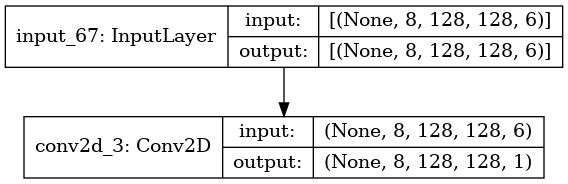

In [347]:
import tensorflow.keras.utils as ku
#ku.plot_model(model, show_shapes=True)

### Setting up the model
The model takes a gridded predictor set as input and outputs gridded fields for each leadtime and for three quantiles. The tempearture forecast on yr.no has both a deterministic best guess and a 10-90% confidence interval. We want the model to predict all three parameters simultaneously.

In [348]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Concatenate,Conv3D,LeakyReLU, Dense, Conv2D, ConvLSTM2D)

num_quantiles = 3
num_outputs = num_quantiles * num_leadtimes

# Construct the input layer with no definite frame size.
inp = Input(shape=([8,128,128,6]))

# 1 ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)

x = Conv2D(
    filters=1, kernel_size=(2, 2), activation="sigmoid", padding="same"
)(inp)
print("x",x)
# Next, we will build the complete model and compile it.
model = tf.keras.models.Model(inp, x)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2), loss = "mse")
model.summary()

x KerasTensor(type_spec=TensorSpec(shape=(None, 8, 128, 128, 1), dtype=tf.float32, name=None), name='conv2d_1109/Sigmoid:0', description="created by layer 'conv2d_1109'")
Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_133 (InputLayer)       [(None, 8, 128, 128, 6)]  0         
_________________________________________________________________
conv2d_1109 (Conv2D)         (None, 8, 128, 128, 1)    25        
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_outputs

### Training the model
We will split the dataset into a training and evaluation set, based on the record dimension.

In [ ]:
Itrain = range(predictors.shape[0]//2)
Ieval = range(predictors.shape[0]//2, predictors.shape[0])
num_epochs = 50
batch_size = 4
model.fit(predictors[Itrain, ...], target[Itrain, ...], epochs=num_epochs, batch_size=batch_size)

### Predict output

In [11]:
output = model.predict(predictors[Ieval, ...])

2021-08-13 17:04:26.565755: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2341011456 exceeds 10% of free system memory.
2021-08-13 17:04:28.901367: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1146617856 exceeds 10% of free system memory.


## Model evaluation and visualization

### Evaluating the model
First, lets compare the mean absolute error of the raw forecast and the ML-forecast of the median

In [12]:
import numpy as np
print("Raw model MAE:", np.nanmean(np.abs(raw_forecast[Ieval, ...] - target[Ieval, ...])), "°C")
print("ML MAE:", np.nanmean(np.abs(output[:, :, :, 0:num_leadtimes] - target[Ieval, ...])), "°C")

Raw model MAE: 1.1301652 °C
ML MAE: 0.8665128 °C


Next, we can plot the MAE as a function of leadtime:

Text(0, 0.5, 'Mean absolute error (°C)')

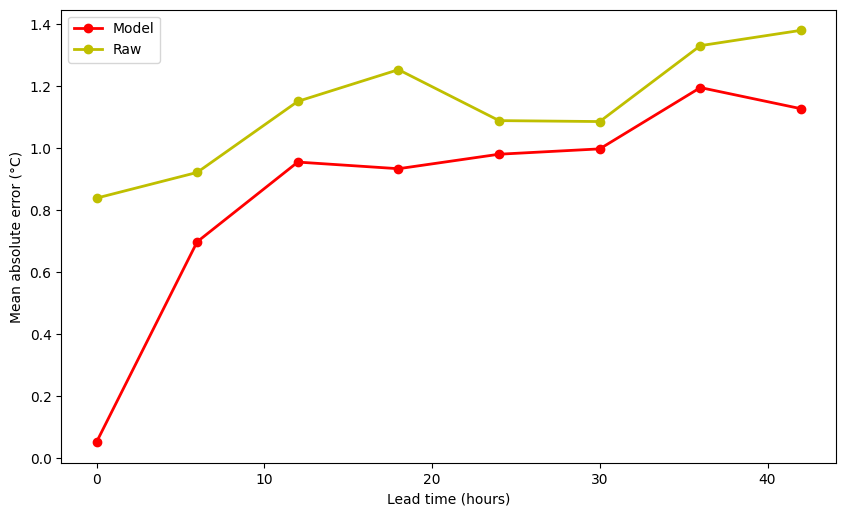

In [13]:
x = ds["leadtime"].astype(float) / 3600 / 1e9
plt.plot(x, [np.nanmean(np.abs(output[:, :, :, i] - target[Ieval, :, :, i])) for i in range(num_leadtimes)], 'ro-', lw=2, label="Model")
plt.plot(x, [np.nanmean(np.abs(raw_forecast[Ieval, :, :, i] - target[Ieval, :, :, i])) for i in range(num_leadtimes)], 'yo-', lw=2, label="Raw")
plt.legend()
plt.xlabel("Lead time (hours)")
plt.ylabel("Mean absolute error (°C)")


### Visualizing the results as timeseries
We can visualize the output as a timeseries. We will pick an example point (Oslo).

Text(0, 0.5, 'Air temperature (°C)')

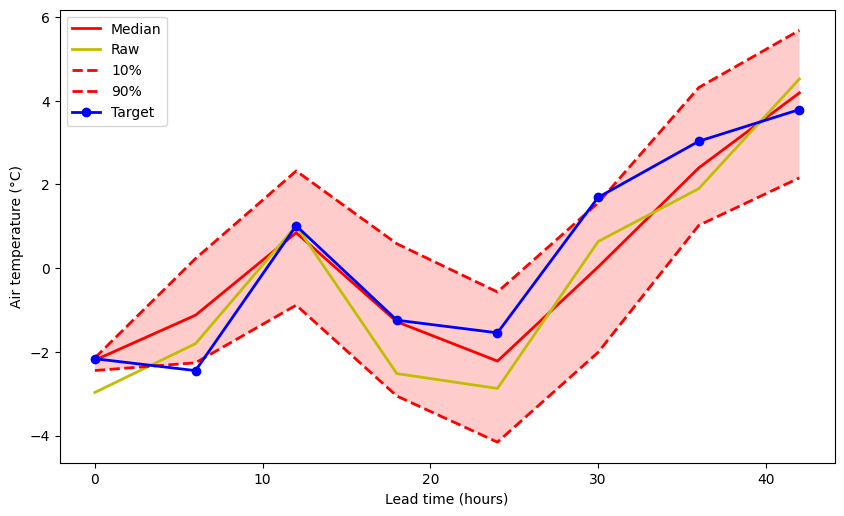

In [14]:
Y = 55
X = 55
plt.plot(x, output[0, Y, X, 0:num_leadtimes], 'r-', lw=2, label="Median")
plt.plot(x, raw_forecast[Ieval[0], Y, X, 0:num_leadtimes], 'y-', lw=2, label="Raw")
lower = output[0, Y, X,num_leadtimes:2*num_leadtimes]
upper = output[0, Y, X, 2*num_leadtimes:3*num_leadtimes]
plt.plot(x, lower, 'r--', lw=2, label="10%")
plt.plot(x, upper, 'r--', lw=2, label="90%")
xx = np.concatenate((x, x[::-1]))
plt.fill(np.concatenate((x, x[::-1])), np.concatenate((lower, upper[::-1])), color='r', alpha=0.2, linewidth=0)
plt.plot(x, target[Ieval[0], Y, X, :], 'bo-', lw=2, label="Target")
plt.legend()
plt.xlabel("Lead time (hours)")
plt.ylabel("Air temperature (°C)")

### Visualizing the results on a map

Text(0.5, 1.0, 'Target (median)')

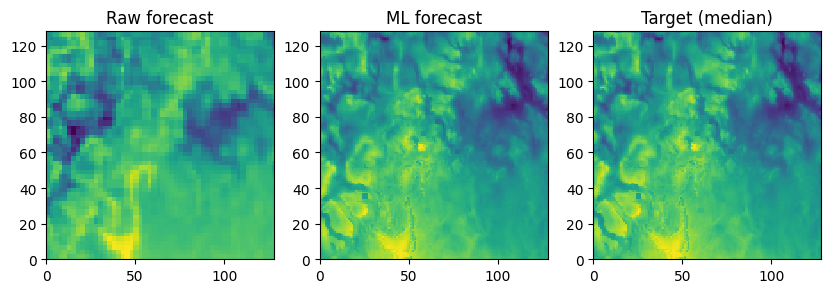

In [15]:
plt.subplot(1, 3, 1)
plt.pcolormesh(raw_forecast[Ieval[0], :, :, 0], rasterized=True)
plt.gca().set_aspect(1)
plt.title("Raw forecast")

plt.subplot(1, 3, 2)
plt.pcolormesh(output[0, :, :, 0], rasterized=True)
plt.gca().set_aspect(1)
plt.title("ML forecast")

plt.subplot(1, 3, 3)
plt.pcolormesh(target[Ieval[0], :, :, 0], rasterized=True)
plt.gca().set_aspect(1)
plt.title("Target (median)")